In [15]:
#CELL 1
from google.colab import drive
import os
import zipfile

# Kết nối với Google Drive
drive.mount('/content/drive')

# Định nghĩa đường dẫn
project_dir = "/content/drive/MyDrive/Project_Gki"
os.makedirs(project_dir, exist_ok=True)
zip_path = os.path.join(project_dir, "StanfordCars.zip")
extracted_dir = "/content/stanford_cars"

# Giải nén file zip nếu chưa giải nén
if not os.path.exists(extracted_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_dir)
    print("Đã giải nén StanfordCars.zip")
else:
    print("Thư mục stanford_cars đã tồn tại, không cần giải nén.")

KeyboardInterrupt: 

In [ ]:
#CELL 2
!pip install pyvi

import json
import os
import random
from collections import Counter
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import transforms, models
from PIL import Image
from pyvi import ViTokenizer

print("Đã import tất cả thư viện cần thiết!")

In [3]:
#CELL 3 không cần run nếu có file JSON

!pip install transformers

from transformers import BlipProcessor, BlipForQuestionAnswering


# Tải mô hình BLIP
try:
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    print(f"Mô hình BLIP đã được tải và chuyển sang {device}")
except Exception as e:
    print(f"Lỗi khi tải mô hình BLIP: {str(e)}")

# Định nghĩa danh sách câu hỏi cố định
question_templates = [
    "How many cars are in the image?",
    "What is the color of the car?",
    "What type of car is this?",
    "What brand is this car?",
    "Where is the car located?"
]

# Ánh xạ sang tiếng Việt
question_translations = {
    "How many cars are in the image?": "Có bao nhiêu xe trong ảnh?",
    "What is the color of the car?": "Màu sắc của xe là gì?",
    "What type of car is this?": "Đây là loại xe gì?",
    "What brand is this car?": "Xe này được sản xuất bởi hãng nào?",
    "Where is the car located?": "Xe trong ảnh đang ở đâu?"
}

# Hàm dịch đơn giản từ tiếng Anh sang tiếng Việt
def simple_translate(text):
    translations = {
        "one": "một", "two": "hai", "three": "ba", "four": "bốn", "five": "năm",
        "car": "xe", "red": "đỏ", "blue": "xanh dương", "green": "xanh lá",
        "black": "đen", "white": "trắng", "silver": "bạc", "gray": "xám",
        "yellow": "vàng", "sedan": "sedan", "suv": "SUV", "sports car": "xe thể thao",
        "truck": "xe tải", "toyota": "Toyota", "honda": "Honda", "bmw": "BMW",
        "mercedes": "Mercedes", "audi": "Audi", "ford": "Ford", "yes": "có",
        "no": "không", "street": "đường phố", "parking lot": "bãi đỗ xe",
        "garage": "garage", "parked": "đỗ", "moving": "di chuyển"
    }
    text_lower = text.lower()
    words = text_lower.split()
    translated_words = []
    for word in words:
        translated_words.append(translations.get(word, word))
    translated = " ".join(translated_words)
    if "xe" not in translated and "chiếc" not in translated and any(num in translated for num in ["một", "hai", "ba", "bốn", "năm"]):
        translated += " chiếc xe"
    if translated and translated[-1] not in [".", "!", "?"]:
        translated += "."
    return translated.capitalize()

# Tạo cặp câu hỏi-trả lời từ ảnh
def generate_qa_with_vqa_model(image_path):
    try:
        image = Image.open(image_path).convert('RGB')
        filename = os.path.basename(image_path)
        qa_pairs = []
        for question_en in question_templates:
            inputs = processor(image, question_en, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model.generate(**inputs)
                answer_en = processor.decode(outputs[0], skip_special_tokens=True)
            question_vi = question_translations[question_en]
            answer_vi = simple_translate(answer_en)
            qa_pairs.append({"image": filename, "question": question_vi, "answer": answer_vi})
        return qa_pairs
    except Exception as e:
        print(f"Lỗi khi xử lý ảnh {image_path}: {str(e)}")
        return [{"image": os.path.basename(image_path), "question": "Có bao nhiêu xe trong ảnh?", "answer": "Không xác định được."}]

# Tạo dataset từ thư mục ảnh
def create_dataset_with_vqa(image_dir, output_file, sample_size=None):
    all_qa_pairs = []
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg'))]
    if sample_size and sample_size < len(image_files):
        image_files = random.sample(image_files, sample_size)
    print(f"Đang tạo bộ dữ liệu từ {len(image_files)} hình ảnh...")
    for i, image_file in enumerate(image_files):
        image_path = os.path.join(image_dir, image_file)
        print(f"Đang xử lý ảnh {i+1}/{len(image_files)}: {image_file}")
        qa_pairs = generate_qa_with_vqa_model(image_path)
        all_qa_pairs.extend(qa_pairs)
        if (i + 1) % 10 == 0:
            with open(output_file + "_temp.json", 'w', encoding='utf-8') as f:
                json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(all_qa_pairs, f, ensure_ascii=False, indent=2)
    print(f"Đã tạo {len(all_qa_pairs)} cặp câu hỏi-trả lời trong file {output_file}")
    return all_qa_pairs

IMAGE_DIR = os.path.join(extracted_dir, "cars_train/cars_train")
OUTPUT_FILE = "/content/questions_answers_vqa.json"
qa_pairs = create_dataset_with_vqa(IMAGE_DIR, OUTPUT_FILE, sample_size=None)  # số lượng ảnh

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Streaming output truncated to the last 5000 lines.
Đang xử lý ảnh 3146/8144: 05050.jpg
Đang xử lý ảnh 3147/8144: 03627.jpg
Đang xử lý ảnh 3148/8144: 01433.jpg
Đang xử lý ảnh 3149/8144: 08101.jpg
Đang xử lý ảnh 3150/8144: 03929.jpg
Đang xử lý ảnh 3151/8144: 07452.jpg
Đang xử lý ảnh 3152/8144: 02505.jpg
Đang xử lý ảnh 3153/8144: 01832.jpg
Đang xử lý ảnh 3154/8144: 00942.jpg
Đang xử lý ảnh 3155/8144: 00872.jpg
Đang xử lý ảnh 3156/8144: 07185.jpg
Đang xử lý ảnh 3157/8144: 04565.jpg
Đang xử lý ảnh 3158/8144: 05171.jpg
Đang xử lý ảnh 3159/8144: 05339.jpg
Đang xử lý ảnh 3160/8144: 04446.jpg
Đang xử lý ảnh 3161/8144: 08048.jpg
Đang xử lý ảnh 3162/8144: 05537.jpg
Đang xử lý ảnh 3163/8144: 05782.jpg
Đang xử lý ảnh 3164/8144: 07394.jpg
Đang xử lý ảnh 3165/8144: 02735.jpg
Đang xử lý ảnh 3166/8144: 07902.jpg
Đang xử lý ảnh 3167/8144: 00233.jpg
Đang xử lý ảnh 3168/8144: 05883.jpg
Đang xử lý ảnh 3169/8144: 01819.jpg
Đang xử lý ảnh 3170/8144: 05409.jpg
Đang xử lý ảnh 3171/8144: 01468.jpg
Đang xử lý ản

In [4]:
# Cell 4: Cải tiến kiến trúc mô hình VQA với fine-tuning CNN
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Chuẩn bị biến đổi ảnh với data augmentation
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Biến đổi ảnh cho validation/test (không augment)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Cải tiến lớp Attention với cơ chế multi-head
class ImprovedAttention(nn.Module):
    def __init__(self, img_dim, question_dim, hidden_dim, num_heads=4, dropout=0.1):
        super(ImprovedAttention, self).__init__()
        self.num_heads = num_heads
        self.hidden_dim = hidden_dim
        self.head_dim = hidden_dim // num_heads
        assert self.head_dim * num_heads == hidden_dim, "hidden_dim phải chia hết cho num_heads"

        # Các phép biến đổi tuyến tính
        self.img_proj = nn.Linear(img_dim, hidden_dim)
        self.question_proj = nn.Linear(question_dim, hidden_dim)
        self.output_proj = nn.Linear(hidden_dim, hidden_dim)

        # Dropout để giảm overfitting
        self.dropout = nn.Dropout(dropout)

        # Layer normalization để ổn định huấn luyện
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, img_features, question_features):
        batch_size = img_features.size(0)

        # Nếu img_features không phải 3D, thêm chiều ở giữa
        if len(img_features.shape) == 2:
            img_features = img_features.unsqueeze(1)

        seq_len = img_features.size(1)

        # Chiếu question_features thành [batch_size, seq_len, hidden_dim]
        question_features = question_features.unsqueeze(1).expand(-1, seq_len, -1)

        # Chiếu đặc trưng đầu vào
        img_proj = self.img_proj(img_features)  # [batch_size, seq_len, hidden_dim]
        question_proj = self.question_proj(question_features)  # [batch_size, seq_len, hidden_dim]

        # Phân chia cho multi-head attention
        img_heads = img_proj.view(batch_size, seq_len, self.num_heads, self.head_dim)
        question_heads = question_proj.view(batch_size, seq_len, self.num_heads, self.head_dim)

        # Tính attention scores
        attention_scores = torch.sum(img_heads * question_heads, dim=-1) / (self.head_dim ** 0.5)  # [batch_size, seq_len, num_heads]
        attention_weights = F.softmax(attention_scores, dim=1)  # [batch_size, seq_len, num_heads]
        attention_weights = self.dropout(attention_weights)

        # Mở rộng attention weights và áp dụng
        attention_weights = attention_weights.unsqueeze(-1).expand(-1, -1, -1, self.head_dim)  # [batch_size, seq_len, num_heads, head_dim]
        weighted_features = img_heads * attention_weights  # [batch_size, seq_len, num_heads, head_dim]

        # Tổng hợp theo seq_len
        attended_features = weighted_features.sum(dim=1)  # [batch_size, num_heads, head_dim]
        attended_features = attended_features.reshape(batch_size, self.hidden_dim)  # [batch_size, hidden_dim]

        # Đầu ra với residual connection và layer norm
        attended_features = self.output_proj(attended_features)
        attended_features = self.dropout(attended_features)

        # Nếu img_features ban đầu là 2D, thì lấy giá trị đầu tiên để cộng residual
        if len(img_features.shape) == 3 and img_features.size(1) == 1:
            residual = self.img_proj(img_features.squeeze(1))
        else:
            # Lấy giá trị trung bình nếu có nhiều feature vector
            residual = self.img_proj(img_features.mean(dim=1))

        return self.layer_norm(attended_features + residual)

# Cải tiến ImageEncoder với spatial features
class ImprovedImageEncoder(nn.Module):
    def __init__(self, img_dim, fine_tune=True, fine_tune_layers=None):
        super(ImprovedImageEncoder, self).__init__()
        # Sử dụng ResNet50 pre-trained
        resnet = models.resnet18(pretrained=True)

        # Loại bỏ lớp global average pooling và fully connected cuối
        modules = list(resnet.children())[:-2]  # Giữ lại đặc trưng không gian
        self.features = nn.Sequential(*modules)

        # Lớp conv để giảm số kênh và kích thước đặc trưng
        self.conv_reduce = nn.Conv2d(512, img_dim, kernel_size=1)

        # Global average pooling
        self.pool = nn.AdaptiveAvgPool2d((1, 1))

        # Lớp fully connected với dropout
        self.fc = nn.Sequential(
            nn.Linear(img_dim, img_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Điều chỉnh fine-tuning
        if fine_tune and fine_tune_layers is not None:
            for param in self.features[:-fine_tune_layers].parameters():
                param.requires_grad = False
        elif fine_tune and fine_tune_layers is not None:
            # Freeze các tầng đầu, chỉ fine-tune các tầng cuối
            children = list(self.features.children())
            for i, child in enumerate(children):
                if i < len(children) - fine_tune_layers:
                    for param in child.parameters():
                        param.requires_grad = False
                else:
                    for param in child.parameters():
                        param.requires_grad = True

    def forward(self, images):
        # Trích xuất đặc trưng từ ResNet
        features = self.features(images)  # [batch_size, 2048, h, w]

        # Giảm số kênh
        reduced = self.conv_reduce(features)  # [batch_size, img_dim, h, w]

        # Lấy đặc trưng toàn cục
        global_features = self.pool(reduced).view(reduced.size(0), -1)  # [batch_size, img_dim]
        global_features = self.fc(global_features)

        return global_features

# Cải tiến QuestionEncoder với LSTM hai chiều
class ImprovedQuestionEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.3):
        super(ImprovedQuestionEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size // 2,  # Chia 2 vì chúng ta sẽ kết hợp 2 hướng
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,  # LSTM hai chiều
            dropout=dropout if num_layers > 1 else 0
        )
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, questions, lengths=None):
        embedded = self.dropout(self.embedding(questions))

        if lengths is not None and lengths.max() > 0:
            packed = pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)
            _, (hidden, _) = self.lstm(packed)
        else:
            _, (hidden, _) = self.lstm(embedded)

        # Kết hợp trạng thái ẩn từ lớp LSTM cuối cùng (2 hướng)
        hidden_concat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # [batch_size, hidden_size]

        return self.fc(hidden_concat)

# Cải tiến Decoder với dropout và attention
class ImprovedDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, dropout=0.3):
        super(ImprovedDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTMCell(embed_size + hidden_size, hidden_size)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, input_token, hidden, cell, context):
        embedded = self.dropout(self.embedding(input_token.view(-1))).squeeze(1)

        # Kết hợp embedding với context vector
        lstm_input = torch.cat([embedded, context], dim=1)  # [batch_size, embed_size + hidden_size]

        # LSTM cell
        hidden_next, cell_next = self.lstm(lstm_input, (hidden, cell))

        # Layer normalization và dropout
        hidden_next = self.layer_norm(hidden_next)
        hidden_next = self.dropout(hidden_next)

        # Dự đoán từ tiếp theo
        output = self.fc(hidden_next)  # [batch_size, vocab_size]

        return output, hidden_next, cell_next

# Cải tiến mô hình VQA tổng thể
class ImprovedVQAModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, img_dim, fine_tune=True, fine_tune_layers=None, dropout=0.3):
        super(ImprovedVQAModel, self).__init__()
        self.image_encoder = ImprovedImageEncoder(img_dim, fine_tune=fine_tune, fine_tune_layers=fine_tune_layers)
        self.question_encoder = ImprovedQuestionEncoder(vocab_size, embed_size, hidden_size, dropout=dropout)
        self.attention = ImprovedAttention(img_dim, hidden_size, hidden_size)
        self.fusion = nn.Sequential(
            nn.Linear(img_dim + hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder = ImprovedDecoder(vocab_size, embed_size, hidden_size, dropout=dropout)
        self.vocab_size = vocab_size

    def forward(self, images, questions, answers=None, question_lengths=None, teacher_forcing_ratio=0.5, max_len=20):
        teacher_forcing_ratio = max(0.5 - epoch * 0.05, 0.0)  # Giảm dần trong vòng lặp epoch
        # Mã hóa ảnh và câu hỏi
        batch_size = images.size(0)
        device = images.device

        # Mã hóa ảnh
        img_features = self.image_encoder(images)  # [batch_size, img_dim]

        # Mã hóa câu hỏi
        question_features = self.question_encoder(questions, question_lengths)  # [batch_size, hidden_size]

        # Áp dụng attention
        attended_img = self.attention(img_features.unsqueeze(1), question_features)  # [batch_size, hidden_size]

        # Kết hợp đặc trưng ảnh và câu hỏi
        fused_features = self.fusion(torch.cat([attended_img, question_features], dim=1))  # [batch_size, hidden_size]

        # Khởi tạo trạng thái LSTM
        hidden = fused_features  # [batch_size, hidden_size]
        cell = torch.zeros_like(hidden).to(device)  # [batch_size, hidden_size]

        # Xác định độ dài tối đa cho đầu ra
        # Điều chỉnh max_len dựa trên answers nếu có
        if answers is not None:
            target_max_len = answers.size(1)  # Lấy độ dài thực tế của targets
        else:
            target_max_len = max_len

        # Khởi tạo đầu vào cho decoder
        decoder_input = torch.tensor([token_to_id['<sos>']] * batch_size).unsqueeze(1).to(device)  # [batch_size, 1]

        # Khởi tạo tensor đầu ra
        outputs = torch.zeros(batch_size, target_max_len, self.vocab_size).to(device)

        # Vòng lặp giải mã đến độ dài cần thiết
        for t in range(target_max_len):
            # Dự đoán token tiếp theo
            output, hidden, cell = self.decoder(decoder_input, hidden, cell, fused_features)
            outputs[:, t] = output  # [batch_size, vocab_size]

            # Teacher forcing: sử dụng từ thực tế với xác suất teacher_forcing_ratio

            use_teacher_forcing = random.random() < teacher_forcing_ratio

            if use_teacher_forcing and answers is not None and t < answers.size(1) - 1:
                decoder_input = answers[:, t].unsqueeze(1)
            else:
                # Sử dụng token dự đoán với xác suất cao nhất
                decoder_input = output.argmax(dim=1).unsqueeze(1)

        return outputs

In [5]:
# Cell 5: Cải tiến xử lý dữ liệu và tạo từ vựng
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Hàm chuyển văn bản thành chuỗi token với xử lý tốt hơn
def text_to_sequence(text, token_to_id, max_len=None):
    tokens = ViTokenizer.tokenize(text.lower()).split()
    tokens.append('<eos>')
    if max_len and len(tokens) > max_len:
        tokens = tokens[:max_len-1] + ['<eos>'] if max_len >= 2 else ['<eos>']
    return [token_to_id.get(token, token_to_id['<unk>']) for token in tokens]

    return [token_to_id.get(token, token_to_id['<unk>']) for token in tokens]

# Tạo từ vựng từ file JSON với lọc từ hiếm
def build_vocab(qa_pairs, min_freq=2):
    word_counts = Counter()
    print("Đang xây dựng từ điển...")

    for pair in tqdm(qa_pairs):
        word_counts.update(ViTokenizer.tokenize(pair['question'].lower()).split())
        word_counts.update(ViTokenizer.tokenize(pair['answer'].lower()).split())

    # Chỉ giữ các từ xuất hiện ít nhất min_freq lần
    common_words = [word for word, count in word_counts.items() if count >= min_freq]
    vocab = ['<pad>', '<sos>', '<eos>', '<unk>'] + common_words
    token_to_id = {token: idx for idx, token in enumerate(vocab)}
    id_to_token = {idx: token for token, idx in token_to_id.items()}

    print(f"Kích thước từ điển: {len(vocab)} từ")
    return token_to_id, id_to_token

# Chia dữ liệu thành tập train, validation và test
def split_data(qa_pairs, val_size=0.1, test_size=0.1):
    # Nhóm QA theo ảnh để đảm bảo các câu hỏi của cùng một ảnh nằm trong cùng một tập
    image_to_qa = {}
    for qa in qa_pairs:
        image = qa['image']
        if image not in image_to_qa:
            image_to_qa[image] = []
        image_to_qa[image].append(qa)

    # Chia theo ảnh
    images = list(image_to_qa.keys())
    train_imgs, temp_imgs = train_test_split(images, test_size=(val_size+test_size), random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=test_size/(val_size+test_size), random_state=42)

    # Tạo các tập dữ liệu
    train_qa = [qa for img in train_imgs for qa in image_to_qa[img]]
    val_qa = [qa for img in val_imgs for qa in image_to_qa[img]]
    test_qa = [qa for img in test_imgs for qa in image_to_qa[img]]

    print(f"Tập huấn luyện: {len(train_qa)} cặp QA ({len(train_imgs)} ảnh)")
    print(f"Tập kiểm định: {len(val_qa)} cặp QA ({len(val_imgs)} ảnh)")
    print(f"Tập kiểm tra: {len(test_qa)} cặp QA ({len(test_imgs)} ảnh)")

    return train_qa, val_qa, test_qa

# Cải tiến Dataset cho huấn luyện
class ImprovedVQADataset(Dataset):
    def __init__(self, qa_pairs, image_dir, token_to_id, max_len=20, transform=None):
        self.qa_pairs = qa_pairs
        self.image_dir = image_dir
        self.token_to_id = token_to_id
        self.max_len = max_len
        self.transform = transform if transform else image_transform

    def __len__(self):
        return len(self.qa_pairs)

    def __getitem__(self, idx):
        try:
            pair = self.qa_pairs[idx]
            image_path = os.path.join(self.image_dir, pair['image'])

            # Xử lý ảnh
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)

            # Xử lý câu hỏi và câu trả lời
            question = text_to_sequence(pair['question'], self.token_to_id, self.max_len)
            answer = text_to_sequence(pair['answer'], self.token_to_id, self.max_len)

            # Tạo answer_input cho teacher forcing (bỏ token EOS cuối, thêm SOS đầu)
            answer_input = [self.token_to_id['<sos>']] + answer[:-1]

            return {
                'image': image,
                'question': torch.tensor(question),
                'question_len': len(question),
                'answer': torch.tensor(answer),
                'answer_input': torch.tensor(answer_input),
                'answer_len': len(answer)
            }

        except Exception as e:
            print(f"Lỗi khi xử lý mục {idx}, ảnh {pair['image'] if 'pair' in locals() else 'unknown'}: {str(e)}")

            # Trả về giá trị mặc định an toàn
            dummy_image = torch.zeros(3, 224, 224)
            dummy_q = torch.tensor([self.token_to_id['<unk>'], self.token_to_id['<eos>']])
            dummy_a = torch.tensor([self.token_to_id['<unk>'], self.token_to_id['<eos>']])
            dummy_a_in = torch.tensor([self.token_to_id['<sos>'], self.token_to_id['<unk>']])

            return {
                'image': dummy_image,
                'question': dummy_q,
                'question_len': 2,
                'answer': dummy_a,
                'answer_input': dummy_a_in,
                'answer_len': 2
            }

# Hàm collate cải tiến cho DataLoader
def improved_collate_fn(batch):
    # Sắp xếp theo độ dài câu hỏi giảm dần
    batch = sorted(batch, key=lambda x: x['question_len'], reverse=True)

    max_answer_len = max([item['answer_len'] for item in batch])
    max_question_len = max([item['question_len'] for item in batch])

    images = torch.stack([item['image'] for item in batch])

    # Đảm bảo tất cả các chuỗi có cùng độ dài
    questions = []
    question_lengths = []
    answers = []
    answer_inputs = []

    for item in batch:
        # Xử lý câu hỏi
        q_padded = F.pad(
            item['question'],
            (0, max_question_len - item['question_len']),
            'constant',
            0
        )
        questions.append(q_padded)
        question_lengths.append(item['question_len'])

        # Xử lý câu trả lời
        a_padded = F.pad(
            item['answer'],
            (0, max_answer_len - item['answer_len']),
            'constant',
            0
        )
        answers.append(a_padded)

        # Xử lý answer inputs (với SOS token)
        a_in_padded = F.pad(
            item['answer_input'],
            (0, max_answer_len - item['answer_len']),
            'constant',
            0
        )
        answer_inputs.append(a_in_padded)

    # Chuyển đổi list thành tensor
    questions = torch.stack(questions)
    question_lengths = torch.tensor(question_lengths)
    answers = torch.stack(answers)
    answer_inputs = torch.stack(answer_inputs)

    return images, questions, question_lengths, answers, answer_inputs

# Load và xử lý dữ liệu
with open(OUTPUT_FILE, 'r', encoding='utf-8') as f:
    qa_pairs = json.load(f)

# Chia dữ liệu
train_qa, val_qa, test_qa = split_data(qa_pairs)

# Xây dựng từ vựng (chỉ sử dụng tập huấn luyện để tránh data leakage)
token_to_id, id_to_token = build_vocab(train_qa, min_freq=2)

# Tạo dataset
train_dataset = ImprovedVQADataset(train_qa, IMAGE_DIR, token_to_id, max_len=20, transform=image_transform)
val_dataset = ImprovedVQADataset(val_qa, IMAGE_DIR, token_to_id, max_len=20, transform=test_transform)
test_dataset = ImprovedVQADataset(test_qa, IMAGE_DIR, token_to_id, max_len=20, transform=test_transform)

print(f"Tạo dataset thành công với {len(train_dataset)} cặp huấn luyện, {len(val_dataset)} cặp kiểm định và {len(test_dataset)} cặp kiểm tra.")

Tập huấn luyện: 32575 cặp QA (6515 ảnh)
Tập kiểm định: 4070 cặp QA (814 ảnh)
Tập kiểm tra: 4075 cặp QA (815 ảnh)
Đang xây dựng từ điển...


  0%|          | 0/32575 [00:00<?, ?it/s]

Kích thước từ điển: 197 từ
Tạo dataset thành công với 32575 cặp huấn luyện, 4070 cặp kiểm định và 4075 cặp kiểm tra.


In [14]:
#CELL 6
# Import các thư viện cần thiết
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.auto import tqdm
import matplotlib.pyplot as plt


# Bật tối ưu cho cuDNN và xóa cache GPU
torch.backends.cudnn.benchmark = True
torch.cuda.empty_cache()

# Định nghĩa thiết bị
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

# Giả định các thành phần đã được định nghĩa trước (nếu chưa, bạn cần thêm)
# - ImprovedVQAModel (định nghĩa lớp mô hình)
# - train_dataset, val_dataset, test_dataset (đã tạo từ ImprovedVQADataset)
# - token_to_id (từ điển token hóa)
# - improved_collate_fn (hàm collate tùy chỉnh)

# Hàm huấn luyện một epoch
def train_epoch(model, dataloader, optimizer, criterion, device, teacher_forcing_ratio, scaler, accumulation_steps=1):
    model.train()
    total_loss = 0
    optimizer.zero_grad()

    for i, (images, questions, question_lengths, answers, answer_inputs) in enumerate(tqdm(dataloader, desc="Training")):
        images = images.to(device)
        questions = questions.to(device)
        question_lengths = question_lengths.to(device)
        answers = answers.to(device)
        answer_inputs = answer_inputs.to(device)

        with autocast():
            outputs = model(images, questions, answer_inputs, question_lengths, teacher_forcing_ratio=teacher_forcing_ratio)
            batch_size, seq_len, vocab_size = outputs.size()
            outputs = outputs.view(batch_size * seq_len, vocab_size)
            answers = answers.view(batch_size * seq_len)
            loss = criterion(outputs, answers)

        scaler.scale(loss / accumulation_steps).backward()  # Chia loss cho accumulation_steps

        if (i + 1) % accumulation_steps == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(dataloader)

# Hàm đánh giá
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, questions, question_lengths, answers, answer_inputs in tqdm(dataloader, desc="Evaluating"):
            images = images.to(device)
            questions = questions.to(device)
            question_lengths = question_lengths.to(device)
            answers = answers.to(device)
            answer_inputs = answer_inputs.to(device)

            with autocast():
                outputs = model(images, questions, answer_inputs, question_lengths, teacher_forcing_ratio=0.0)
                batch_size, seq_len, vocab_size = outputs.size()
                outputs = outputs.view(batch_size * seq_len, vocab_size)
                answers = answers.view(batch_size * seq_len)
                loss = criterion(outputs, answers)

            total_loss += loss.item()

    return total_loss / len(dataloader)

# Thiết lập tham số
VOCAB_SIZE = len(token_to_id)  # Số lượng từ vựng, cần được định nghĩa trước
EMBED_SIZE = 256
HIDDEN_SIZE = 512
IMG_DIM = 512
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
BATCH_SIZE = 64  # Tăng batch size để tối ưu GPU
ACCUMULATION_STEPS = 2  # Gradient accumulation nếu batch size lớn gây hết bộ nhớ

# Khởi tạo mô hình
model = ImprovedVQAModel(
    vocab_size=VOCAB_SIZE,
    embed_size=EMBED_SIZE,
    hidden_size=HIDDEN_SIZE,
    img_dim=IMG_DIM,
    fine_tune=True,
    fine_tune_layers=4,  # Tinh chỉnh nhiều layer hơn
    dropout=0.2  # Giảm dropout để học nhanh hơn
).to(device)

# Loss và optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, ignore_index=token_to_id['<pad>'])  # Thêm label smoothing
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler = OneCycleLR(optimizer, max_lr=0.01, total_steps=NUM_EPOCHS * len(train_dataloader) // ACCUMULATION_STEPS, pct_start=0.3)
scaler = GradScaler()  # Cho mixed precision training

# DataLoader
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=improved_collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2  # Tăng hiệu suất tải dữ liệu
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=improved_collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=improved_collate_fn,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=2
)

# Early stopping
patience = 3
no_improve = 0
best_val_loss = float('inf')

# Huấn luyện
train_losses = []
val_losses = []
for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    teacher_forcing_ratio = max(0.7 - (epoch // 2) * 0.05, 0.0)  # Giảm teacher forcing chậm
    train_loss = train_epoch(model, train_dataloader, optimizer, criterion, device, teacher_forcing_ratio, scaler, ACCUMULATION_STEPS)
    train_losses.append(train_loss)

    val_loss = evaluate(model, val_dataloader, criterion, device)
    val_losses.append(val_loss)

    scheduler.step()  # Cập nhật scheduler
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {optimizer.param_groups[0]['lr']}")

    # Lưu mô hình tốt nhất
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        no_improve = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/Project_Gki/best_vqa_model.pth')
        print("Đã lưu mô hình tốt nhất!")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

# Vẽ biểu đồ loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

# Đánh giá trên tập test
test_loss = evaluate(model, test_dataloader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")

# Lưu mô hình cuối cùng
torch.save(model.state_dict(), '/content/drive/MyDrive/Project_Gki/final_vqa_model.pth')
print("Đã lưu mô hình cuối cùng!")

Sử dụng thiết bị: cuda
Epoch 1/20


<ipython-input-14-b765806440d2>:106: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Cho mixed precision training


Training:   0%|          | 0/509 [00:00<?, ?it/s]

<ipython-input-14-b765806440d2>:38: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

<ipython-input-14-b765806440d2>:70: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.9019 | Val Loss: 1.6900 | LR: 0.00040000254130821353
Đã lưu mô hình tốt nhất!
Epoch 2/20


Training:   0%|          | 0/509 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78b7fe7cb740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78b7fe7cb740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78b7fe7cb740>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x78b7fe7cb740>^
Traceback (most recent call last):
^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^    ^self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^
if w.is_alive():A

Train Loss: 1.7226 | Val Loss: 1.6930 | LR: 0.0004000101652301639
Epoch 3/20


Training:   0%|          | 0/509 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/64 [00:00<?, ?it/s]

Train Loss: 1.7128 | Val Loss: 1.6831 | LR: 0.0004000228717577804
Đã lưu mô hình tốt nhất!
Epoch 4/20


Training:   0%|          | 0/509 [00:00<?, ?it/s]

KeyboardInterrupt: 

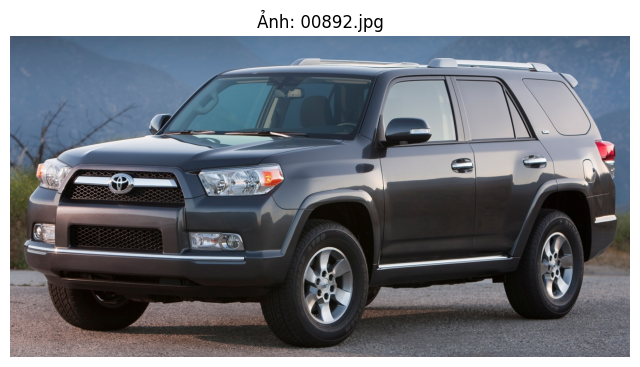

Câu hỏi: Có bao nhiêu xe trong ảnh?
Câu trả lời dự đoán: 1 .
Câu trả lời thực tế: Một chiếc xe.
--------------------------------------------------
Câu hỏi: Màu sắc của xe là gì?
Câu trả lời dự đoán: đen .
Câu trả lời thực tế: Grey.
--------------------------------------------------
Câu hỏi: Đây là loại xe gì?
Câu trả lời dự đoán: sedan .
Câu trả lời thực tế: Toyota.
--------------------------------------------------
Câu hỏi: Xe này được sản xuất bởi hãng nào?
Câu trả lời dự đoán: ford .
Câu trả lời thực tế: Toyota.
--------------------------------------------------
Câu hỏi: Xe trong ảnh đang ở đâu?
Câu trả lời dự đoán: parking lot .
Câu trả lời thực tế: On road.
--------------------------------------------------


In [12]:
#CELL 7
import matplotlib.image as mpimg
from torchvision import transforms

# Hàm dự đoán câu trả lời
def predict_answer(model, image_path, question, token_to_id, id_to_token, max_len=20, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Xử lý ảnh
        try:
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Lỗi khi mở ảnh {image_path}: {str(e)}")
            return None

        # Áp dụng transform để chuẩn hóa ảnh
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        image = transform(image).unsqueeze(0).to(device)  # [1, 3, 224, 224]

        # Xử lý câu hỏi
        question_seq = text_to_sequence(question, token_to_id, max_len)
        question_tensor = torch.tensor(question_seq).unsqueeze(0).to(device)  # [1, seq_len]
        question_lengths = torch.tensor([len(question_seq)]).to(device)

        # Trích xuất đặc trưng
        img_features = model.image_encoder(image)  # [1, img_dim]
        question_features = model.question_encoder(question_tensor, question_lengths)  # [1, hidden_size]
        attended_img = model.attention(img_features.unsqueeze(1), question_features)  # [1, hidden_size]

        # Kết hợp đặc trưng
        fused_features = model.fusion(torch.cat([attended_img, question_features], dim=1))  # [1, hidden_size]

        # Khởi tạo trạng thái LSTM
        hidden = fused_features  # [1, hidden_size]
        cell = torch.zeros_like(hidden).to(device)  # [1, hidden_size]

        # Khởi tạo đầu vào cho decoder
        decoder_input = torch.tensor([token_to_id['<sos>']]).unsqueeze(0).to(device)  # [1, 1]

        # Sinh câu trả lời
        answer = []
        for _ in range(max_len):
            output, hidden, cell = model.decoder(decoder_input, hidden, cell, fused_features)
            pred_token = output.argmax(dim=-1).item()
            if pred_token == token_to_id['<eos>']:
                break
            answer.append(id_to_token[pred_token])
            decoder_input = torch.tensor([pred_token]).unsqueeze(0).to(device)

        return ' '.join(answer)

# Kiểm tra kết quả trên một ảnh mẫu
# Chọn ảnh đầu tiên từ tập dữ liệu
image_file = qa_pairs[20]['image']  # Lấy ảnh đầu tiên trong qa_pairs
image_path = os.path.join(IMAGE_DIR, image_file)

# Hiển thị ảnh
try:
    img = mpimg.imread(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Ảnh: {image_file}")
    plt.show()
except Exception as e:
    print(f"Lỗi khi hiển thị ảnh {image_path}: {str(e)}")

# Lấy tất cả câu hỏi và câu trả lời thực tế liên quan đến ảnh này
questions_for_image = [item['question'] for item in qa_pairs if item['image'] == image_file]
real_answers_for_image = [item['answer'] for item in qa_pairs if item['image'] == image_file]

# Dự đoán và hiển thị kết quả
for question, real_answer in zip(questions_for_image, real_answers_for_image):
    predicted_answer = predict_answer(model, image_path, question, token_to_id, id_to_token, device=device)
    print(f"Câu hỏi: {question}")
    print(f"Câu trả lời dự đoán: {predicted_answer}")
    print(f"Câu trả lời thực tế: {real_answer}")
    print("-" * 50)